# Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Import training set

In [2]:
dataset_train = pd.read_csv('../../data/google-stock-price/Google_Stock_Price_Train.csv')
dataset_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [3]:
# create numpy array
training_set = dataset_train.iloc[:,1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

## Feature scaling (Normalization)

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

## Creating Timesteps

In [10]:
training_set_scaled.shape[0]

1258

In [17]:
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [5]:
X_train = []
y_train = []

for i in range(60, training_set_scaled.shape[0]): # from 60 days back till the end (1258)
    X_train.append(training_set_scaled[i - 60 : i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train , y_train = np.array(X_train), np.array(y_train)

In [16]:
X_train.shape , y_train.shape

((1198, 60), (1198,))

## Reshape inputs

In [6]:
X_train_shaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] , 1)) # (batch_size, timesteps, number of predictors)

# Build RNN

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization

## Design the model

In [8]:
# Initilize
regressor = Sequential()

# Add layers
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_shaped.shape[1], 1))) # (shape -> (timesteps, predictors))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))


In [9]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Compile the model

In [12]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train the model

In [13]:
regressor.fit(X_train_shaped, y_train, epochs = 100, batch_size = 32)

Epoch 1/100


38/38 [==============================] - 8s 64ms/step - loss: 0.0418
Epoch 2/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0074
Epoch 3/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 3s 86ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0055
Epoch 6/100
38/38 [==============================] - 3s 89ms/step - loss: 0.0055
Epoch 7/100
38/38 [==============================] - 4s 96ms/step - loss: 0.0050
Epoch 8/100
38/38 [==============================] - 3s 92ms/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0052
Epoch 10/100
38/38 [==============================] - 3s 92ms/step - loss: 0.0046
Epoch 11/100
38/38 [==============================] - 4s 100ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 4s 99ms/step - loss: 0.0044
Epoch 13/100
38/38 [================

# Make Predictions

## Read test data

In [17]:
dataset_test = pd.read_csv('../../data/google-stock-price/Google_Stock_Price_Test.csv')
real_stock_data = dataset_test.iloc[:,1:2].values # real google stock price

## Preprocess test data

In [20]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

# dummy
inputs[1:10]

array([[0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685]])

In [21]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Run Prediction

In [22]:
predicted_stock_price = regressor.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [23]:
# inverse transform to remove scaling
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [26]:
predicted_stock_price.shape, real_stock_data.shape

((20, 1), (20, 1))

# Visualize op

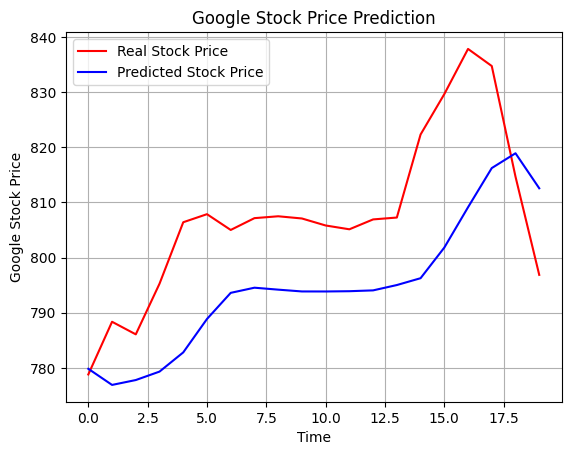

In [28]:
plt.plot(real_stock_data, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid()
plt.show()